In [1]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2023-09-20 01:42:25--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.02s   

2023-09-20 01:42:25 (56.5 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [2]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [ ]:
vocab = sorted(list(set(text)))
vocab_size = len(vocab)

In [ ]:
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}
len(stoi), len(itos)

(65, 65)

In [ ]:
encode = lambda x: [stoi[ch] for ch in x]
decode = lambda x: ''.join([itos[ch] for ch in x])
out = encode("hi")
out, decode(out)

([46, 47], 'hi')

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
data = torch.tensor(encode(text), dtype=torch.long)
data.shape

torch.Size([1115394])

In [ ]:
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

In [ ]:
torch.manual_seed(342)
batch_size = 4
block_size = 8

def get_batch(split, batch_size=4, block_size=8):
  '''
  Returns a batch of inputs and outputs for specified split
  '''
  data = train_data if split == "train" else val_data
  indexes = torch.randint(len(data)-block_size, (batch_size, ))
  x = torch.stack([data[ix:ix+block_size] for ix in indexes])
  y = torch.stack([data[ix+1:ix+block_size+1] for ix in indexes])
  return x, y

xb, yb = get_batch("train")
print(xb.shape, yb.shape)
xb, yb

torch.Size([4, 8]) torch.Size([4, 8])


(tensor([[ 1, 57, 59, 47, 58, 10,  0, 13],
         [61, 43,  1, 57, 46, 39, 50, 50],
         [ 1, 51, 53, 56, 43,  1, 41, 39],
         [57, 58, 43, 56,  6,  1, 58, 43]]),
 tensor([[57, 59, 47, 58, 10,  0, 13, 52],
         [43,  1, 57, 46, 39, 50, 50,  1],
         [51, 53, 56, 43,  1, 41, 39, 59],
         [58, 43, 56,  6,  1, 58, 43, 50]]))

In [ ]:
class BiagramLanguageModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, x, targets=None):
    '''
    Forwards the network
    Returns loss if target is specified.

    Args:
      x: input tensor of shape (B, T)
      target: Output of shape (B, T)
    '''
    logits = self.token_embedding_table(x) # (B, T, C)
    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  def generate(self, x, max_length=10):
    '''
    Generates sequence of characters using model given input
    Args:
      x: input of shape (B, T)
      max_length: length of the output tokens
    '''
    for i in range(max_length):
      logits, loss = self.forward(x) # (B, T, C), (1)
      logits = logits[:, -1, :] # (B, C)
      probs = F.softmax(logits, dim=-1) # We want probs for multinomial to work
      pred = torch.multinomial(probs, num_samples=1) # (B, 1)
      x = torch.cat((x, pred), dim=1)
    return x


torch.manual_seed(234)
model = BiagramLanguageModel()
xb, yb = get_batch("train")
# logits, loss = model(xb, yb)
# print(logits.shape)
# print(loss)

temp = torch.zeros((1, 1), dtype=torch.long)
out = model.generate(temp) # (B, max_length)
decode(out[0].tolist())


'\nD$-KaygvCj'

In [ ]:
import time

def calculate_time(func):
  def w(*args, **kwargs):
    start = time.time()
    func(*args, **kwargs)
    end = time.time()
    print(f'Time take: {(end - start):.5f}')
  return w

  0%|          | 0/10000 [00:00<?, ?it/s]

4.716723918914795
3.5310568809509277
2.8968346118927
2.6393890380859375
2.5491580963134766
2.4921469688415527
2.4711904525756836
2.4620399475097656
2.442924737930298
2.4669454097747803


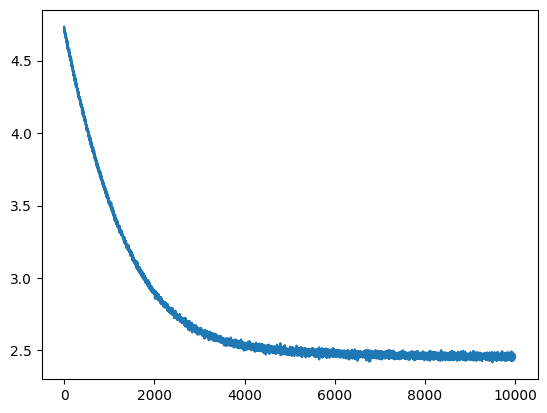

In [ ]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model = BiagramLanguageModel().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

# Simple training
batch_size = 1024
epochs = 100_00
losses = []
for i in tqdm(range(epochs)):
  xb, yb = get_batch("train", batch_size=batch_size)
  xb, yb = xb.to(device), yb.to(device)

  logits, loss = model(xb, yb)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # stats
  losses.append(loss.item())
  if i%1000 == 0:
    print(loss.item())

plt.plot(range(len(losses)), losses)



In [ ]:
temp = torch.zeros((1, 1), dtype=torch.long).to(device)
out = model.generate(temp) # (B, max_length)
decode(out[0].tolist())


'\nmout supom'

In [ ]:
a = torch.tril(torch.ones(3, 3))
w = a.masked_fill(a == 0, float("-inf"))
a, w, F.softmax(w, dim=1)

(tensor([[1., 0., 0.],
         [1., 1., 0.],
         [1., 1., 1.]]),
 tensor([[1., -inf, -inf],
         [1., 1., -inf],
         [1., 1., 1.]]),
 tensor([[1.0000, 0.0000, 0.0000],
         [0.5000, 0.5000, 0.0000],
         [0.3333, 0.3333, 0.3333]]))

# Self-attention for single head

In [ ]:
torch.manual_seed(1324)
BLOCK_SIZE = 8
BATCH_SIZE = 4
HEAD_SIZE = 16
xb, yb = get_batch("train", block_size=BLOCK_SIZE, batch_size=BATCH_SIZE)
xb, yb # (B, T)

B, T = xb.shape
C = 32 # This is our embd dimension (just using random value here for now)

x = torch.randn((B, T, C))
key = nn.Linear(C, HEAD_SIZE, bias=False)
value = nn.Linear(C, HEAD_SIZE, bias=False)
query = nn.Linear(C, HEAD_SIZE, bias=False)
k = key(x) # B, T, HEAD_SIZE
q = query(x) # B, T, HEAD_SIZE
v = value(x) # B, T, HEAD_SIZE

w = q @ k.transpose(-1, -2) # (B, T, HEAD_SIZE) @ (B, T, HEAD_SIZE) -> (B, T, T)
B, T, T = w.shape
tril = torch.tril(torch.ones(T, T))
w = w.masked_fill(tril == 0, float('-inf'))
w = F.softmax(w, dim=-1)


out = w @ v # (B, T, T) @ (B, T, HEAD_SIZE) -> (B, T, HEAD_SIZE)





## Full code

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16
block_size = 32
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0


torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()


chars = sorted(list(set(text)))
vocab_size = len(chars)

# Mappings
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])


# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [25]:
class SelfAttention(nn.Module):
  def __init__(self, head_size):
    """
    Implementation of self attention

    NOTE: This should only be used with MultiHeadAttention cause It doesn't return the same shape as input
    """

    super().__init__()
    self.k = nn.Linear(n_embd, head_size)
    self.q = nn.Linear(n_embd, head_size)
    self.v = nn.Linear(n_embd, head_size)

    # used when we want it to be stored in state_dict but not trainable, can access using self.tril
    self.register_buffer("tril", torch.tril(
            torch.ones(block_size, block_size)))

    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    '''
    Args:
      x: input of shape (B, T, n_embd)
    '''
    B, T, C = x.shape

    k = self.k(x) # (B, T, n_head)
    q = self.q(x) # (B, T, n_head)
    v = self.v(x) # (B, T, n_head)

    w = q @ k.transpose(-2, -1) * C**-0.5 # (B, T, T)

    # IMPORTANT: [:T, :T] cause the shape of x will be undefined when generation.
    w = w.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
    w = F.softmax(w, dim=-1) # (B, T, T)
    w = self.dropout(w)

    out = w @ v # (B, T, n_head)
    # print(f"k {k.shape}, q: {q.shape}, v: {v.shape}, out: {out.shape}")
    return out

class MultiHeadAttention(nn.Module):
  def __init__(self, n_heads, head_size):
    """
    Implementation of Masked multihead attention

    NOTE: This is unusual implementation of MultiHeadAttention, normally we combine everything in single k, q, v.
    IMPORTANT: We have to define all the SelfAttention blocks in here in order for them to produce different values
    """
    super().__init__()
    self.selfAttention = nn.ModuleList([SelfAttention(head_size=head_size) for _ in range(n_heads)])
    self.projection = nn.Linear(n_embd, n_embd)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    """
    Args:
      x: inputs of shape (B, T, C)
        B: batch_size
        T: block_size
        C: n_embd
    """
    x = torch.cat([l(x) for l in self.selfAttention], dim=-1) # (B, T, head_size) * n_heads
    # out = torch.cat(out, dim=-1) # (B, T, head_size * n_heads) -> (B, T, C)
    x = self.dropout(self.projection(x))
    return x


class FeedForward(nn.Module):
  """
  Performs feed forward after the MultiHeadAttention
  """
  def __init__(self, n_embd):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(n_embd, 4 * n_embd),
        nn.ReLU(),
        nn.Linear(4 * n_embd, n_embd),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    return self.layers(x)

class Block(nn.Module):
  def __init__(self, n_embd, n_heads):
    super().__init__()
    head_size = n_embd // n_heads
    self.attention = MultiHeadAttention(n_heads=n_heads, head_size=head_size)
    self.ln1 = nn.LayerNorm(n_embd)
    self.ln2 = nn.LayerNorm(n_embd)
    self.ffw = FeedForward(n_embd)

  def forward(self, x):
    x = x + self.attention(self.ln1(x)) # (B, T, C)
    x = x + self.ffw(self.ln2(x)) # (B, T, C)
    return x


class GPT(nn.Module):
  def __init__(self):
    super().__init__()
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd) # (vocab_size, C)
    self.position_embedding = nn.Embedding(block_size, n_embd) # (T, C)
    self.block = Block(n_embd, n_heads=n_heads)
    self.ln = nn.LayerNorm(n_embd)
    self.final = nn.Linear(n_embd, vocab_size)

  def forward(self, x, targets=None):
    '''
    GPT forward pass
    Args:
      x: input of shape (B, T)
      targets: targets of shape (B, T)
    '''
    B, T = x.shape
    token_emb = self.token_embedding_table(x) # (B, T, C)
    pos_emb = self.position_embedding(torch.arange(T, device=device)) # (T, C)
    x = token_emb + pos_emb # (B, T, C)
    attention = self.block(x) # (B, T, C)
    out = self.ln(attention) # (B, T, C) ,.. [C is n_embd]
    logits = self.final(out) # (B, T, vocab_size)

    if targets == None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  def generate0(self, x, max_seq_len=100):
    """
    For generating outputs from the model given a input x
    Args:
      x: input of shape (B, T).
    """
    x = x.to(device)
    for i in range(max_seq_len):
      logits, loss = self(x)
      logits = logits[:, -1, :] # (B, C)
      logits = F.softmax(logits, dim=-1)
      pred = torch.multinomial(logits, num_samples=1) # (B, 1)
      x = torch.cat([x, pred], dim=-1)  # (B, ?)
    return x

  def generate(self, idx, max_new_tokens=10):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :]  # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1)  # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1)  # (B, T+1)
        return idx


# torch.manual_seed(1345)
# xb, yb = get_batch("train")
# m = GPT(n_heads=4)
# m = m.to(device)
# logits, loss = m(xb)

# fg = torch.zeros((batch_size, block_size)).type(torch.long)

In [45]:
from tqdm.auto import tqdm

batch_size = 16  # how many independent sequences will we process in parallel?
block_size = 32  # what is the maximum context length for predictions?
max_iters = 50000
eval_interval = 100
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embd = 64
n_heads = 4
n_layer = 4
dropout = 0.0


model = GPT()
model = model.to(device)
# model.load_state_dict(torch.load("nano_gpt.pt"))
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-4)
train_loss = []

def train(model,
          optimizer,
          epochs):
  model.train()

  for epoch in tqdm(range(epochs)):
    xb, yb = get_batch("train")
    xb, yb = xb.to(device), yb.to(device)

    logits, loss = model(xb, yb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # stats
    train_loss.append(loss.item())


In [50]:
train(model=model,
      optimizer=optimizer,
      epochs=max_iters)

  0%|          | 0/5000 [00:00<?, ?it/s]

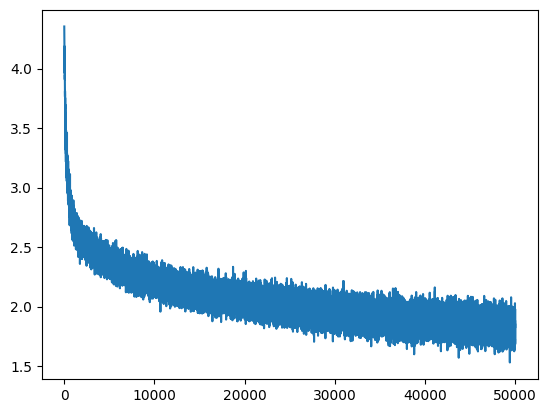

In [47]:
import matplotlib.pyplot as plt
plt.plot(range(len(train_loss)), train_loss)

In [51]:
torch.save(model.state_dict(), "nano_gpt.pt")

In [52]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=2000)[0].tolist()))



Rhard! As I
Murgen, bour in saccure, I have my dost
them
And the spit claus, you birnes of mard haveate bowill it!

VORSHEN:
Santry fathink stoplers are Is ble:
And I may you forthing and farseed onest:
Than! Whan sholy. Withis the contence.

ISAP:
Dair, or dider Soct born.

First in un, it 'Batch'd, his good the him cablood;
er's, you! pake, faition re'er a perset
So my my our all and the depins.

JULING HENRY:
Maded Eypare sepower'd do thy so hope of dares of is the night Garrow:
Here if that do boy; Lod in death;
So lova, for I never; felf; would I'll I hould and I does, if beat; swithnusy,
And good why shafful ill'st him?.
Comese vour enef, toither.
I faturs dain: i' nows no and I.
3 Proversusmenter, Which say:
Ourd son lot woo it weath.

Py bid so teath you my ong.

ROMIO:
Why adgan, To-mut gik?
A good me, hear, more'd.

ROMINA:
Which you crom cons the diegieve sre do is of in fean,
Letting in OxI'll am chit a great and knows there it sousmil! Will parly hass:
My ence aburratch,

## Demo of updated ig self attention :).

In [68]:
t = torch.randn((4, 5))
att = torch.tril(torch.ones(6, 6))
print(att)
print(t)
B, T = t.shape
t.masked_fill(att[:B, :T] == 0, float("-inf"))

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])
tensor([[-0.0935, -0.5471, -0.3707, -0.0740, -0.1041],
        [ 0.2176,  0.4699,  0.7482, -1.3293, -0.8264],
        [-0.7590,  0.1958,  0.9548, -1.6906,  0.3653],
        [-0.6173,  0.2967, -0.4332,  0.9150, -1.9382]])


tensor([[-0.0935,    -inf,    -inf,    -inf,    -inf],
        [ 0.2176,  0.4699,    -inf,    -inf,    -inf],
        [-0.7590,  0.1958,  0.9548,    -inf,    -inf],
        [-0.6173,  0.2967, -0.4332,  0.9150,    -inf]])